In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from deap import base, creator, tools

from matplotlib import pyplot as plt

In [2]:
dataset = pd.read_csv('dataset.csv', delimiter=';', low_memory='False')

In [3]:
#Drop columns that are not needed
dataset = dataset.drop(['user','gender','age','how_tall_in_meters','weight','body_mass_index'], axis=1)

In [4]:

#Centering
scaler = StandardScaler(with_mean=True, with_std=False)
dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']] = scaler.fit_transform(dataset[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']])


In [5]:
#Getting the means
means = dataset.groupby('Class')[['x1','y1','z1','x2','y2','z2','x3','y3','z3','x4','y4','z4']].mean()


In [6]:
#Separating means for the sitting state and the other states
sitting_mean = means.T.pop('sitting').T
states_means = means.T.drop('sitting', axis=1).T

sitting_mean

x1    -0.486084
y1   -22.306565
z1    43.635725
x2    28.910872
y2    -3.106982
z2    87.851017
x3     5.975411
y3   -16.033985
z3    -1.506830
x4    35.909071
y4   -17.211905
z4    -2.330129
Name: sitting, dtype: float64

In [7]:
states_means

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
Class,,,,,,,,,,,,
sittingdown,4.760175,8.224046,-22.260180,-5.823379,-13.600041,7.620686,-8.966171,1.685927,3.775952,-15.432958,-3.437820,18.822701
standing,0.157898,9.454739,-13.615081,69.255961,105.897156,30.120579,5.579103,3.606117,5.904483,-10.540946,7.306341,2.334467
standingup,1.233943,3.038834,-26.903694,-14.638464,-22.975549,-3.290510,-24.499793,-47.574437,-10.894834,-27.935515,0.165405,5.767685
walking,-1.255743,12.595985,-22.288397,-103.568370,-101.704300,-136.530879,-3.609479,27.925607,-2.599721,-18.194113,12.997469,-6.610483


In [8]:
states_means = np.array(states_means)
sitting_mean = np.array(sitting_mean)


In [9]:
#Making the genetic algorithm

w = []
for _ in range(0,12):
    w.append(1.0)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, -617,533)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=12)
                 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)




def evaluate(v):
    c=0.1
    
    v= np.array(v).reshape(1,-1)
    other_states_sum = 0
    
    for state in states_means:
        other_states_sum += cosine_similarity(v,state.reshape(1,-1))
    
    f = ((cosine_similarity(v,sitting_mean.reshape(1,-1)) + c*(1 - 0.25 * other_states_sum)))/ (1 + c) + 1
    
    return f[0]



toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=0.1, low=-617, up=533)
toolbox.register("mutate", tools.mutUniformInt, low=-617,up=533, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=4)
#toolbox.register("select", tools.selRoulette)
toolbox.register("evaluate", evaluate)


    

In [10]:
def ga():
    pop = toolbox.population(n=200)
    CXPB, MUTPB, NGEN = 0.1, 0.01, 1000
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    g=0
    
    max_fits=1
    prev_max_fits=1
    max_fits_list=[]
    
    bad_improvement_counter=0
    
    best_solution=[]
        
    while g<NGEN and bad_improvement_counter<20 and max_fits<2:
        
       
        
        print("\n----GEN "+ str(g+1) +"----\n")
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        
        # Clone the selected individuals
             
        offspring =list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
        
            if random.random() < CXPB:
                toolbox.mate(child1,child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        best_solution = pop[fits.index(max(fits))]
        
        prev_max_fits = max_fits
        max_fits = max(fits)
        max_fits_list.append(max_fits)
        
        improvement = (max_fits/prev_max_fits)-1
        
        if improvement < 0.001:
            bad_improvement_counter+=1
        else:
            bad_improvement_counter=0

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
        g+=1
        


    return best_solution, max_fits_list,g
    

In [11]:
solutions=[]
max_fits=[]
generations=[]

for _ in range(20):
    solution, max_fit,gen = ga()
    solutions.append(solution)
    max_fits.append(max_fit)
    generations.append(gen)
    
mean_fit = pd.DataFrame(max_fits).mean()



----GEN 1----

  Min 0.6751875806348702
  Max 1.6557531601421798
  Avg 1.2970696204483105
  Std 0.1710873592063627

----GEN 2----

  Min 1.162801285361152
  Max 1.6557531601421798
  Avg 1.468562414273329
  Std 0.09658464411270332

----GEN 3----

  Min 1.0821318132601243
  Max 1.7006073818457548
  Avg 1.5559498388044244
  Std 0.05528732771953249

----GEN 4----

  Min 1.2370518576849534
  Max 1.7400086487071333
  Avg 1.593942218164659
  Std 0.05525468013298222

----GEN 5----

  Min 1.3334131701624319
  Max 1.7910439588043914
  Avg 1.6435595901888156
  Std 0.05652898099468956

----GEN 6----

  Min 1.5401110599439312
  Max 1.7910439588043914
  Avg 1.6976017289606964
  Std 0.032522827801023384

----GEN 7----

  Min 1.5063673864443161
  Max 1.825394742557152
  Avg 1.7266194705352629
  Std 0.042558114112679686

----GEN 8----

  Min 1.5443822794150557
  Max 1.8666233419596172
  Avg 1.7600202578214725
  Std 0.03578968998016015

----GEN 9----

  Min 1.523222216146553
  Max 1.9009392817409232
  

  Min 1.8735901580879855
  Max 1.9345773206147627
  Avg 1.9326322420188888
  Std 0.005001280755420119

----GEN 25----

  Min 1.932866698852699
  Max 1.9345773206147627
  Avg 1.93352302101479
  Std 0.00042029561225889137

----GEN 26----

  Min 1.6787648454296566
  Max 1.9346232105806815
  Avg 1.9326693164702342
  Std 0.018004829019841847

----GEN 27----

  Min 1.9335301355962904
  Max 1.9346245157985824
  Avg 1.93444049088388
  Std 0.00024562693715360936

----GEN 1----

  Min 0.8381658067051121
  Max 1.6281161758418592
  Avg 1.2987694565087802
  Std 0.16178265672893524

----GEN 2----

  Min 1.1940166673950057
  Max 1.7314396347428436
  Avg 1.474347463534581
  Std 0.1126951970901256

----GEN 3----

  Min 1.2986165788861117
  Max 1.7625238831696248
  Avg 1.5809875147073222
  Std 0.07154456290643724

----GEN 4----

  Min 1.536233391721228
  Max 1.7681454810021286
  Avg 1.6410622975252738
  Std 0.046203384258238424

----GEN 5----

  Min 1.5260859016367205
  Max 1.7681454810021286
  Avg 1.68

  Min 1.879661807499041
  Max 1.9465483744700975
  Avg 1.9377024263134957
  Std 0.004478738207656586

----GEN 25----

  Min 1.887645568119349
  Max 1.9465483744700975
  Avg 1.9386353109465497
  Std 0.003994436701799318

----GEN 26----

  Min 1.7817813104399987
  Max 1.9465483744700975
  Avg 1.939732372490876
  Std 0.01140465148903285

----GEN 27----

  Min 1.653184979888607
  Max 1.9501978997258216
  Avg 1.940455946121707
  Std 0.024833449535476244

----GEN 28----

  Min 1.9320729242773123
  Max 1.9501978997258216
  Avg 1.9455341418379333
  Std 0.002469265476967179

----GEN 29----

  Min 1.6150813748212016
  Max 1.9501978997258216
  Avg 1.9456839685894665
  Std 0.023478820818074703

----GEN 30----

  Min 1.829175901157667
  Max 1.950848253176403
  Avg 1.9483393729022822
  Std 0.008595637326922463

----GEN 31----

  Min 1.9465878829230117
  Max 1.9511996464425483
  Avg 1.9500597184213155
  Std 0.0005112929935244094

----GEN 32----

  Min 1.847580844106632
  Max 1.9511996464425483
  Avg 

  Min 1.71579366355749
  Max 1.886223269014276
  Avg 1.8151792163273819
  Std 0.034512771308406034

----GEN 9----

  Min 1.5489277691578391
  Max 1.893955007000449
  Avg 1.8456451547626893
  Std 0.036550972279163436

----GEN 10----

  Min 1.6113716848719508
  Max 1.9198597319821715
  Avg 1.8725790404901415
  Std 0.028778554013924273

----GEN 11----

  Min 1.552737469039613
  Max 1.9198597319821715
  Avg 1.883907706675956
  Std 0.029431110433225622

----GEN 12----

  Min 1.8513706455789811
  Max 1.9198597319821715
  Avg 1.8917205634072969
  Std 0.01017057580056213

----GEN 13----

  Min 1.6917819222186838
  Max 1.962834231611649
  Avg 1.898873664893881
  Std 0.025267277651478782

----GEN 14----

  Min 1.7018146175180058
  Max 1.962834231611649
  Avg 1.9124058523939373
  Std 0.02257812791656393

----GEN 15----

  Min 1.3877059882266438
  Max 1.962834231611649
  Avg 1.9165771922073092
  Std 0.050438482917827696

----GEN 16----

  Min 1.7759931559742403
  Max 1.962834231611649
  Avg 1.9252

  Min 1.7924868871829962
  Max 1.9920775275863625
  Avg 1.9904228862643931
  Std 0.014034380357941802

----GEN 34----

  Min 1.8738282712342866
  Max 1.9920775275863625
  Avg 1.9910622937899363
  Std 0.008312049801692529

----GEN 35----

  Min 1.3556406233952203
  Max 1.9920775275863625
  Avg 1.9877289525084936
  Std 0.04565370877006629

----GEN 36----

  Min 1.9722191980308426
  Max 1.9940035683530957
  Avg 1.9917161546606423
  Std 0.0014070961200373492

----GEN 37----

  Min 1.9915892448296058
  Max 1.9940035683530957
  Avg 1.9919464816630381
  Std 0.0003051110547429111

----GEN 38----

  Min 1.455852604006699
  Max 1.9944086457453691
  Avg 1.9894308998771009
  Std 0.03782853729277468

----GEN 39----

  Min 1.7836812717321417
  Max 1.994711914567905
  Avg 1.9914743835769062
  Std 0.01475435694873298

----GEN 40----

  Min 1.672711496015542
  Max 1.994711914567905
  Avg 1.9910026456424805
  Std 0.024959899784248823

----GEN 41----

  Min 1.9920911642281405
  Max 1.9950837168446371
  A

  Min 1.3399075015352448
  Max 1.8561466424291286
  Avg 1.8039464828590368
  Std 0.03967822664004399

----GEN 9----

  Min 1.6667136689445345
  Max 1.8771402834580924
  Avg 1.8147014329538251
  Std 0.018175684475865674

----GEN 10----

  Min 1.1006560590656826
  Max 1.8784740675755378
  Avg 1.8230850827344194
  Std 0.05441038473110767

----GEN 11----

  Min 1.5994194851383945
  Max 1.8923675647421876
  Avg 1.8364863838288712
  Std 0.02843447053660659

----GEN 12----

  Min 1.7861544988928957
  Max 1.935021756843669
  Avg 1.8516018329011834
  Std 0.015808092927971903

----GEN 13----

  Min 1.6948217574800417
  Max 1.9391151775514492
  Avg 1.8630090779702548
  Std 0.027456300639504577

----GEN 14----

  Min 1.84237186687431
  Max 1.9391151775514492
  Avg 1.886423556396096
  Std 0.020181455635041253

----GEN 15----

  Min 1.7052966713761215
  Max 1.9391151775514492
  Avg 1.905590176124154
  Std 0.029777189302453155

----GEN 16----

  Min 1.8334558998436448
  Max 1.948937421918628
  Avg 1.

  Min 1.9751738165346213
  Max 1.9860109642652648
  Avg 1.9821653913392767
  Std 0.0009466666296003395

----GEN 40----

  Min 1.9813149665523486
  Max 1.9860109642652648
  Avg 1.9829622859065212
  Std 0.0010656771621892598

----GEN 41----

  Min 1.9533569443144927
  Max 1.9883396138669642
  Avg 1.9838149450670273
  Std 0.002602525998598209

----GEN 42----

  Min 1.8994632244340162
  Max 1.9899005911272378
  Avg 1.9843464993660171
  Std 0.006641931691690916

----GEN 43----

  Min 1.8829894668529286
  Max 1.9899005911272378
  Avg 1.9856549901256335
  Std 0.007433208447718722

----GEN 44----

  Min 1.754008187733962
  Max 1.9899005911272378
  Avg 1.9851021971102467
  Std 0.018041302338310205

----GEN 45----

  Min 1.6491291569590711
  Max 1.9902319295500843
  Avg 1.9852432357998786
  Std 0.027664353841926573

----GEN 46----

  Min 1.9883396138669642
  Max 1.9902319295500843
  Avg 1.98918502934109
  Std 0.0006570841607429813

----GEN 47----

  Min 1.8649259814723256
  Max 1.990380718851387

  Min 1.674368385786612
  Max 1.8367999335323282
  Avg 1.795459202273753
  Std 0.01618445717188844

----GEN 11----

  Min 1.2453002188237232
  Max 1.8549588121116227
  Avg 1.799462341196668
  Std 0.04784684878755105

----GEN 12----

  Min 1.5152167747410106
  Max 1.8549588121116227
  Avg 1.8186995249082925
  Std 0.025920937558497295

----GEN 13----

  Min 1.4609117866466756
  Max 1.8994918527248175
  Avg 1.8292723344468271
  Std 0.034854485306937265

----GEN 14----

  Min 1.7782523265162056
  Max 1.8994918527248175
  Avg 1.8465841366902702
  Std 0.015229805850705238

----GEN 15----

  Min 1.8367999335323282
  Max 1.8994918527248175
  Avg 1.8613180910999518
  Std 0.015325344876481753

----GEN 16----

  Min 1.8047432714866631
  Max 1.9061196399217435
  Avg 1.8750483865951406
  Std 0.018398506878981105

----GEN 17----

  Min 1.8093839267174041
  Max 1.9061196399217435
  Avg 1.8920260304129675
  Std 0.011590540866471022

----GEN 18----

  Min 1.5432407013660776
  Max 1.9143477349207783
  A

  Min 1.6346995112982485
  Max 1.982501101148877
  Avg 1.9778498293051292
  Std 0.03084706675664996

----GEN 34----

  Min 1.793103832843791
  Max 1.982501101148877
  Avg 1.9796162483544706
  Std 0.014866930760731955

----GEN 35----

  Min 1.5473755390408233
  Max 1.9831373077290555
  Avg 1.9792519457457038
  Std 0.030626724443301417

----GEN 36----

  Min 1.7078323700134255
  Max 1.9831373077290555
  Avg 1.9807200054244354
  Std 0.019356505578051967

----GEN 37----

  Min 1.981148980041346
  Max 1.9832785709039689
  Avg 1.9825593813649365
  Std 0.00019410884367312723

----GEN 38----

  Min 1.6148654250610213
  Max 1.9832785709039689
  Avg 1.9808095704515691
  Std 0.025947455650548783

----GEN 39----

  Min 1.9823263846071666
  Max 1.9833375905897572
  Avg 1.9829565541993375
  Std 0.0002486133098035217

----GEN 40----

  Min 1.8192719932585328
  Max 1.9835372311674266
  Avg 1.9823644112210672
  Std 0.01156184416748777

----GEN 41----

  Min 1.2749945842411505
  Max 1.9835372311674266
 

  Min 1.9355137344281612
  Max 1.9376213711461636
  Avg 1.9373800197527618
  Std 0.0002328734191701708

----GEN 27----

  Min 1.565585562789129
  Max 1.9376213711461636
  Avg 1.9355342239153601
  Std 0.026232239975008325

----GEN 28----

  Min 1.8086913404433598
  Max 1.941493962056265
  Avg 1.9367849900197354
  Std 0.009118273435980321

----GEN 29----

  Min 1.7855408969915798
  Max 1.9425593602022881
  Avg 1.9360969444542746
  Std 0.014588545403096967

----GEN 30----

  Min 1.9373160920695287
  Max 1.9425593602022881
  Avg 1.9380203894051566
  Std 0.0012045077523383009

----GEN 31----

  Min 1.7037879810876158
  Max 1.9426225440135036
  Avg 1.9377746573111165
  Std 0.01669583399389662

----GEN 32----

  Min 1.3623739181701768
  Max 1.9436671221791182
  Avg 1.9351356767888759
  Std 0.05003456783696476

----GEN 33----

  Min 1.938793695181697
  Max 1.943855744589833
  Avg 1.9423561936994655
  Std 0.0005384040555980521

----GEN 34----

  Min 1.919424522356084
  Max 1.943855744589833
  A

  Min 1.8390845578389943
  Max 1.99844639787581
  Avg 1.9968084487179687
  Std 0.015026898172258036

----GEN 35----

  Min 1.6047888523801532
  Max 1.99844639787581
  Avg 1.9951180671388453
  Std 0.03318386457933266

----GEN 36----

  Min 1.9983811099687774
  Max 1.99844639787581
  Avg 1.9984118460818074
  Std 1.059599349393452e-05

----GEN 37----

  Min 1.6474533446409452
  Max 1.99844639787581
  Avg 1.995073743947469
  Std 0.03206126650885272

----GEN 38----

  Min 1.7716142755592912
  Max 1.9984848414329806
  Avg 1.9966091287618901
  Std 0.018691468394818368

----GEN 39----

  Min 1.9984285570812377
  Max 1.9984848414329806
  Avg 1.9984466931073994
  Std 4.038297161442432e-06

----GEN 40----

  Min 1.9929792369381767
  Max 1.9984848414329806
  Avg 1.998420984248971
  Std 0.00038584622646804995

----GEN 41----

  Min 1.9946177083809578
  Max 1.9996621666907974
  Avg 1.9984469221875374
  Std 0.00029655116681598945

----GEN 42----

  Min 1.6241008112645727
  Max 1.9996621666907974
  Av

  Min 1.6823290161589801
  Max 1.8811348821923857
  Avg 1.8160423847010474
  Std 0.01885871339585011

----GEN 10----

  Min 1.259228473188043
  Max 1.8821374889169697
  Avg 1.8297145831834056
  Std 0.04647303470921042

----GEN 11----

  Min 1.2753431190805244
  Max 1.8900986402678903
  Avg 1.8510012649608754
  Std 0.04698499663358734

----GEN 12----

  Min 1.4999252448413714
  Max 1.8900986402678903
  Avg 1.871217812736322
  Std 0.035408769902071396

----GEN 13----

  Min 1.4541099883299473
  Max 1.8907000808046672
  Avg 1.879787643434492
  Std 0.03118242832420458

----GEN 14----

  Min 1.727808506240543
  Max 1.898630573535265
  Avg 1.885162933406199
  Std 0.011920333426024545

----GEN 15----

  Min 1.4976324741682079
  Max 1.9180577610402154
  Avg 1.8867913399490133
  Std 0.02934655917922087

----GEN 16----

  Min 1.5966757518608963
  Max 1.9180577610402154
  Avg 1.8896545500098196
  Std 0.021244312328499333

----GEN 17----

  Min 1.030945084673259
  Max 1.9218192833213648
  Avg 1.88

  Min 1.6538380238456714
  Max 1.962369931296779
  Avg 1.9553633579009801
  Std 0.022147663953989625

----GEN 17----

  Min 1.2432680862610168
  Max 1.962369931296779
  Avg 1.9539456169986844
  Std 0.0513512606728218

----GEN 18----

  Min 1.8924465740557384
  Max 1.9633810629939858
  Avg 1.9592651338576237
  Std 0.005563031130290175

----GEN 19----

  Min 1.9564375555508708
  Max 1.9637515232956688
  Avg 1.9615622232405026
  Std 0.0016196619783011364

----GEN 20----

  Min 1.7704611127638463
  Max 1.9637515232956688
  Avg 1.9609909478624965
  Std 0.015322922976911364

----GEN 21----

  Min 1.1480976409745862
  Max 1.965025028759211
  Avg 1.9586461588892439
  Std 0.05746051731958151

----GEN 22----

  Min 1.9622549246330752
  Max 1.965025028759211
  Avg 1.963184053423977
  Std 0.00039638251385273844

----GEN 23----

  Min 1.6684403116016533
  Max 1.965025028759211
  Avg 1.9617131644315722
  Std 0.02097370132083795

----GEN 24----

  Min 1.6400498996860282
  Max 1.965025028759211
  Avg 

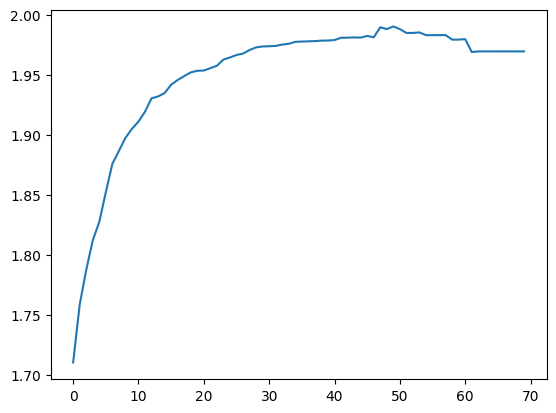

In [12]:
plt.plot(mean_fit)


In [13]:
print("Mean number of generations: " +str(np.mean(generations)))

Mean number of generations: 46.25


In [14]:
best_solution = solutions[max_fits.index(max(max_fits))]
print("Best solution found: "+ str(best_solution))

Best solution found: [-44.95271352066439, -184.92581691812674, 340.788787584791, 189.66452562605517, 11, 532.3586615343447, 63.846109532114454, -147.54773667695426, 17.91081831556128, 312.2141993600837, -137.49467989652743, -165]
